## Cape Cod - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#! python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

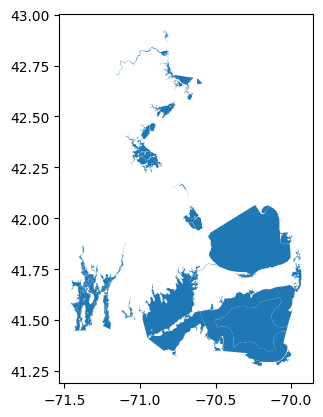

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(10630, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(10630, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits'}

<Axes: >

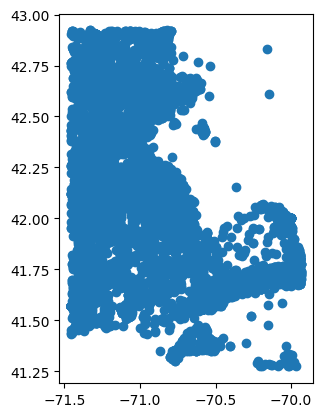

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

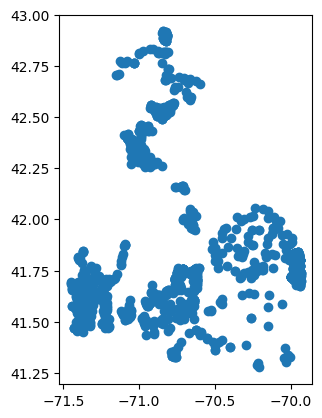

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1544

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,BRC,Blackstone River Coalition (Volunteer),BRC-C-02-02-020:20131012040800:FM:0.2083333333...,2013-10-12,04:08:00,EST,BRC-C-02-02-020,STORET-1039097035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-CND-161:20130818:0651:FM:1,2013-08-18,06:51:00,EDT,OARS-CND-161,STORET-838568413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-SUD-064:20130721:0610:FM:1,2013-07-21,06:10:00,EDT,OARS-SUD-064,STORET-838568309,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,130809111433.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-m41:20131017:FM:B,2013-10-17,NaN,NaN,WTGHA-M41,STORET-1041401688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457247,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,EST,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457248,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457249,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457250,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

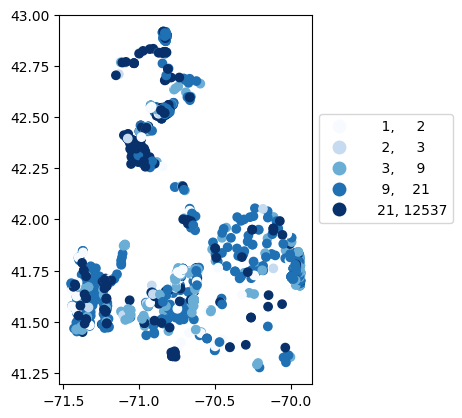

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    4865.000000
mean      -12.374142
std       405.355648
min     -9999.000000
25%         1.600000
50%         3.500000
75%         6.000000
max        17.000000
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2419.7597455697323): 16


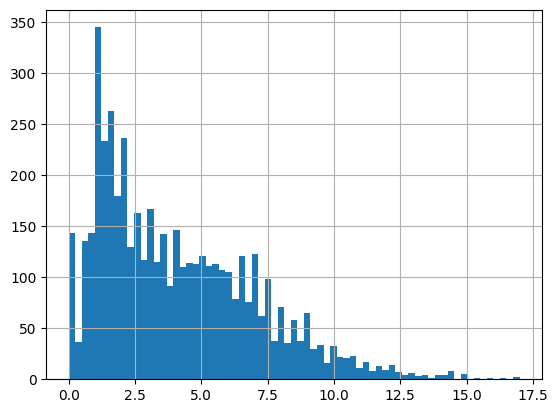

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, "Depth, Secchi disk depth", errors="ignore", intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
48,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
173,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
302,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
668,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
707,11113300-GRTKINSD,4.75,m,NaN,m,4.75 meter
...,...,...,...,...,...,...
456562,11NPSWRD_WQX-CACO_DUCK_W,16.5,m,NaN,m,16.5 meter
456563,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
456564,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
456565,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
12509,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
35869,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
38787,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
40895,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
43072,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
368189,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368293,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368649,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
369416,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
12509,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
35869,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
35993,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
36143,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
37270,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
368189,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368293,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368649,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
369416,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
691,WWMD_VA-SH1,2,1.500000
692,WWMD_VA-SH2,2,1.800000
693,WWMD_VA-SR6A,1,0.500000
694,WWMD_VA-WF2,1,0.600000


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

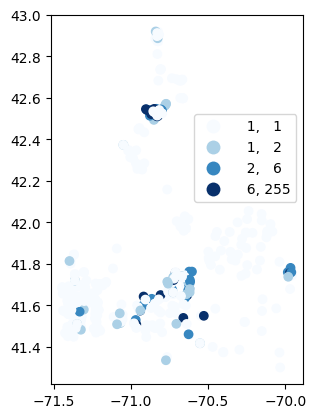

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

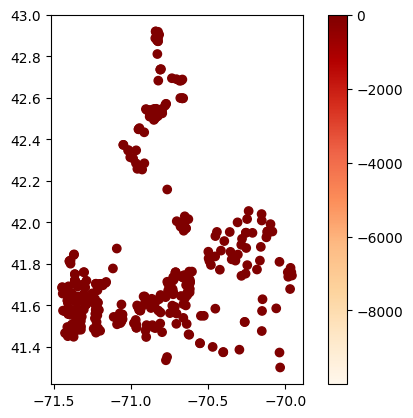

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    125644.000000
mean         16.023829
std           7.328661
min          -6.000000
25%          11.000000
50%          16.800000
75%          21.660000
max         910.000000
dtype: float64
Unusable results: 213
Usable results with inferred units: 217
Results outside threshold (0.0 to 59.99579510818923): 177


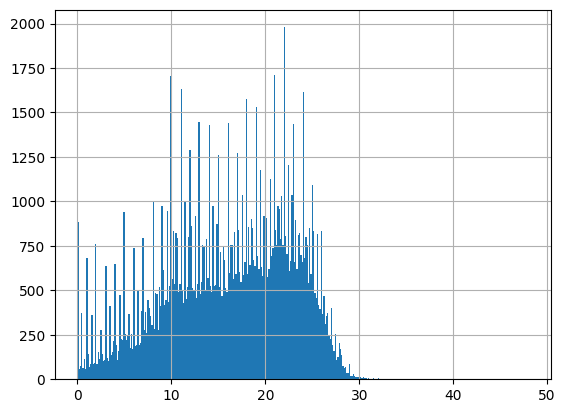

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
1,OARS-CND-161,22.18,deg C,NaN,22.18 degree_Celsius,degC
3,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
5,WTGHA-M43,17.39,deg C,NaN,17.39 degree_Celsius,degC
8,MASSDEP-W2386,20.9,deg C,NaN,20.9 degree_Celsius,degC
12,WTGHA-S35,22.54,deg C,NaN,22.54 degree_Celsius,degC
...,...,...,...,...,...,...
457234,USGS-413831070304703,11.3,deg C,NaN,11.3 degree_Celsius,degC
457236,USGS-01100627,7.0,deg C,NaN,7.0 degree_Celsius,degC
457240,USGS-01096548,2.9,deg C,NaN,2.9 degree_Celsius,degC
457244,USGS-01098530,1.5,deg C,NaN,1.5 degree_Celsius,degC


In [34]:
# Examine deg F
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'] == 'deg F']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
19652,NALMS-F865245,81,deg F,NaN,27.222222222222285 degree_Celsius,degF
28290,11113300-HOODERD,59.2,deg F,NaN,15.111111111111143 degree_Celsius,degF
28661,11113300-HOODERD,59.1,deg F,NaN,15.0555555555556 degree_Celsius,degF
28991,11113300-HOODERD,59.9,deg F,NaN,15.500000000000057 degree_Celsius,degF
29537,11113300-HOODERD,56,deg F,NaN,13.333333333333371 degree_Celsius,degF
...,...,...,...,...,...,...
452878,11NPSWRD_WQX-SAIR_MEQ76_NC6,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF
452882,11NPSWRD_WQX-SAMA_MEQ76_NC13,72.0,deg F,NaN,22.222222222222285 degree_Celsius,degF
452891,11NPSWRD_WQX-SAMA_MEQ76_NC18,71.0,deg F,NaN,21.666666666666686 degree_Celsius,degF
452897,11NPSWRD_WQX-SAIR_MEQ76_NC3,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
127677,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
127678,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
127679,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
127680,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
127681,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
129019,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
129020,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
129022,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
143966,AQUINNAH-MEN PND HC,0.0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
343,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
3512,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
4018,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
5102,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
5498,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
285725,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
301036,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
302367,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
306809,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
5963,WWMD_VA-WWE1149PI,1,18.800000
5964,WWMD_VA-WWE1150PI,1,21.300000
5965,WWMD_VA-WWE1151PI,2,20.700000
5966,WWMD_VA-WWE1152PI,1,20.000000


<Axes: >

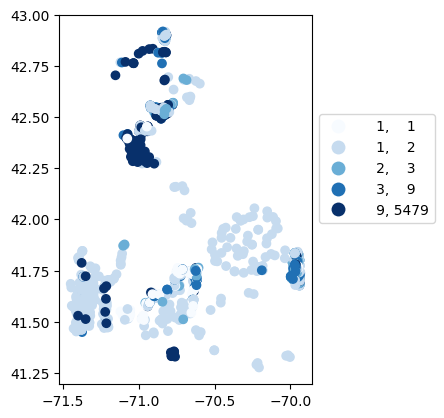

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

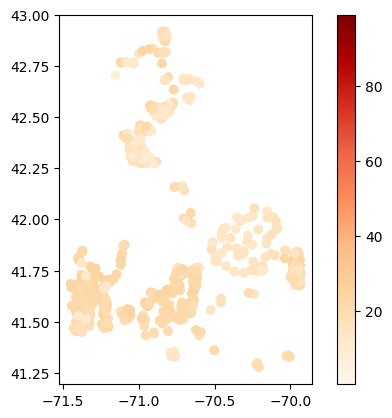

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
14,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
17,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
19,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
22,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
23,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
453729,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
453736,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter
453739,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
453742,11NPSWRD_WQX-SAMA_EPG_SHD,9.2,mg/L,NaN,9.2 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
14,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
17,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
19,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
22,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
23,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
453729,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
453736,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter
453739,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
453742,11NPSWRD_WQX-SAMA_EPG_SHD,9.2,mg/L,NaN,9.2 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2358,WWMD_VA-SR5,1,10.810000
2359,WWMD_VA-WF2,2,6.800000
2360,WWMD_VA-WI1,1,9.510000
2361,WWMD_VA-WR2X,2,6.000000


<Axes: >

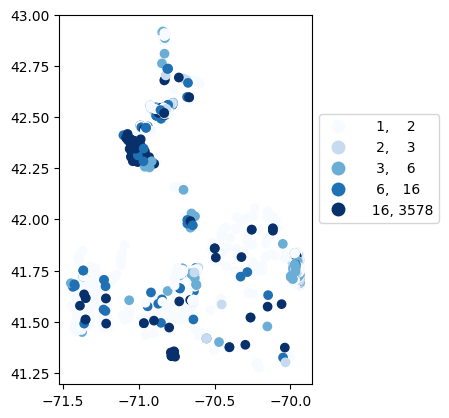

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

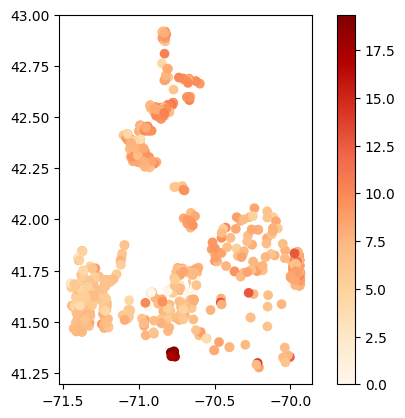

In [46]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'mV' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    100709.000000
mean          6.594211
std           2.583377
min          -3.124705
25%           5.800000
50%           6.700000
75%           7.500000
max         715.000000
dtype: float64
Unusable results: 2210
Usable results with inferred units: 215
Results outside threshold (0.0 to 22.09447506883673): 12


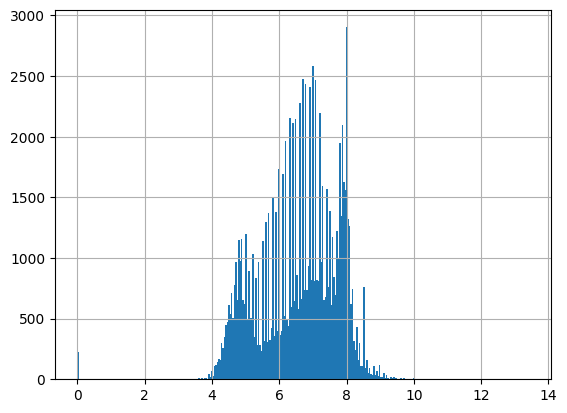

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, "pH", errors="ignore", report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
6,7.3,None,NaN,7.3 dimensionless
9,8.16,None,NaN,8.16 dimensionless
26,7.99,None,NaN,7.99 dimensionless
43,6.61,None,NaN,6.61 dimensionless
45,8.23,None,NaN,8.23 dimensionless
...,...,...,...,...
457235,5.8,std units,NaN,5.8 dimensionless
457237,7.3,std units,NaN,7.3 dimensionless
457241,7.4,std units,NaN,7.4 dimensionless
457245,7.5,std units,NaN,7.5 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/basis.py:154: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn(f"Mismatched {flag}", UserWarning)


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'deg C' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    36923.000000
mean        20.638884
std         25.204451
min          0.000000
25%          0.900000
50%         29.700000
75%         31.380000
max       4003.482834
dtype: float64
Unusable results: 218
Usable results with inferred units: 1
Results outside threshold (0.0 to 171.8655897766306): 2


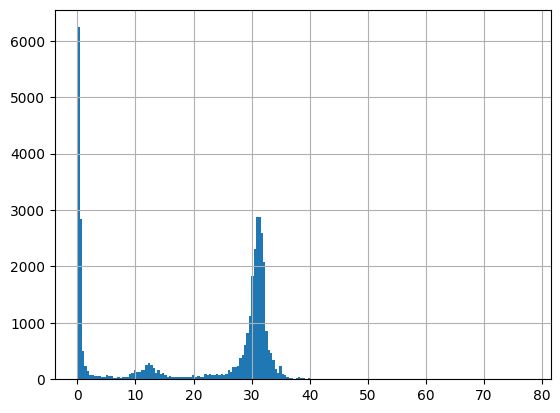

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
10,30.33,ppt,NaN,30.33 Practical_Salinity_Units
51,30.48,ppt,NaN,30.48 Practical_Salinity_Units
56,33.3,ppth,NaN,33.3 Practical_Salinity_Units
72,30.91,ppt,NaN,30.91 Practical_Salinity_Units
76,0.21,ppth,NaN,0.21 Practical_Salinity_Units
...,...,...,...,...
456043,9.9,PSU,NaN,9.9 Practical_Salinity_Units
456648,4.6,PSU,NaN,4.6 Practical_Salinity_Units
456748,21.0,PSU,NaN,21.0 Practical_Salinity_Units
456761,18.7,PSU,NaN,18.7 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


-Usable results-
count    2409.000000
mean        6.472302
std       106.930304
min         0.000800
25%         0.074000
50%         0.242000
75%         1.000000
max      2800.000000
dtype: float64
Unusable results: 243
Usable results with inferred units: 0
Results outside threshold (0.0 to 648.0541246058881): 6


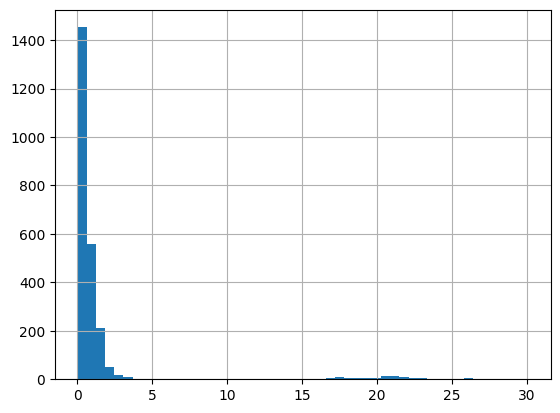

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
840,0.926976,mg/L,NaN,0.926976 milligram / liter
912,1.571196,mg/L,NaN,1.571196 milligram / liter
919,0.816144,mg/L,NaN,0.816144 milligram / liter
1216,0.770448,mg/L,NaN,0.770448 milligram / liter
1253,0.848832,mg/L,NaN,0.848832 milligram / liter
...,...,...,...,...
457068,0.119,mg/l,NaN,0.119 milligram / liter
457126,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
457169,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
457175,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     8694.000000
mean     23607.687800
std      17412.071345
min          0.000000
25%        612.000000
50%      27773.988852
75%      39935.000000
max      57700.000000
dtype: float64
Unusable results: 81
Usable results with inferred units: 0
Results outside threshold (0.0 to 128080.11587319421): 0


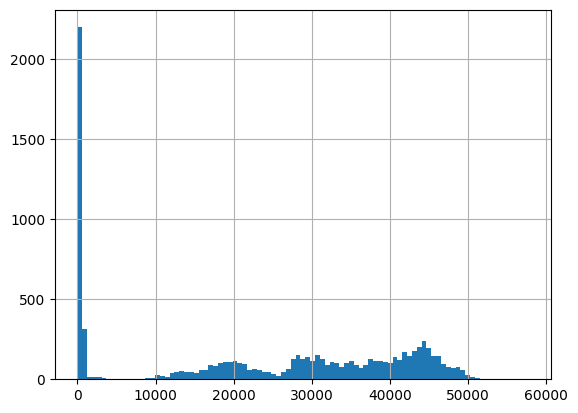

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True, errors='ignore')

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
2,590,uS/cm,NaN,590.0 microsiemens / centimeter
7,43.5,mS/cm,NaN,43500.0 microsiemens / centimeter
49,349,uS/cm,NaN,349.0 microsiemens / centimeter
52,49.7,mS/cm,NaN,49700.0 microsiemens / centimeter
58,8,count,NaN,NaN
...,...,...,...,...
381877,20.579,mS/cm,NaN,20579.0 microsiemens / centimeter
381912,38.432,mS/cm,NaN,38432.0 microsiemens / centimeter
381919,37.791,mS/cm,NaN,37791.0 microsiemens / centimeter
381924,19.003,mS/cm,NaN,19003.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    4171.000000
mean        0.581802
std         3.280718
min        -0.002400
25%         0.001900
50%         0.005200
75%         0.019000
max        92.900000
dtype: float64
Unusable results: 202
Usable results with inferred units: 9
Results outside threshold (0.0 to 20.266111880769866): 29


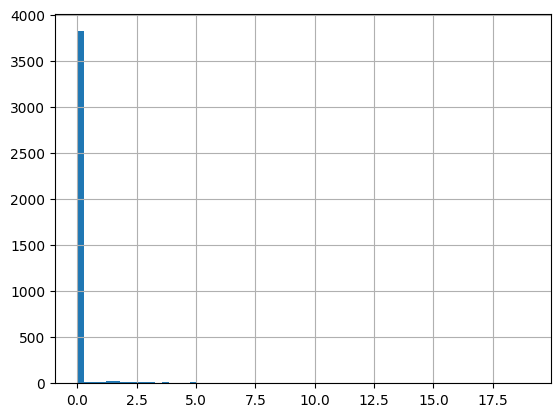

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
13,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
275,5.50,ug/L,NaN,0.0055 milligram / liter
375,9.48,ug/L,NaN,0.00948 milligram / liter
683,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
971,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
456952,0.5,ug/l,NaN,0.0005 milligram / liter
456959,2.5,ug/l,NaN,0.0025 milligram / liter
456972,0.7,ug/l,NaN,0.0007 milligram / liter
457005,1.1,ug/l,NaN,0.0011 milligram / liter


##### Organic Carbon

-Usable results-
count      6141.000000
mean       5287.284256
std       35592.329726
min      -90000.000000
25%           1.740000
50%           4.900000
75%           8.900000
max      530000.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 218841.26261451485): 40


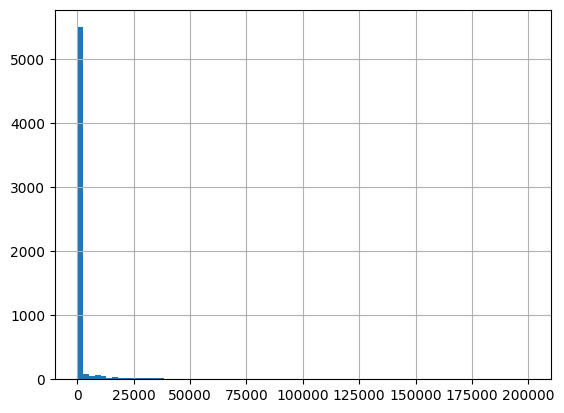

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
965,7.05,mg/L,NaN,7.05 milligram / liter
1097,7.57,mg/L,NaN,7.57 milligram / liter
1150,3.5,mg/L,NaN,3.5 milligram / liter
3027,3.8,mg/L,NaN,3.8 milligram / liter
3852,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
457056,7.01,mg/l,NaN,7.01 milligram / liter
457125,5.96,mg/l,NaN,5.96 milligram / liter
457168,4.1,mg/l,NaN,4.1 milligram / liter
457174,7.79,mg/l,NaN,7.79 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/harmonize.py:149: UserWarning: Bad Turbidity unit: count
  warn(f"Bad Turbidity unit: {unit}")


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    29171.000000
mean        18.052962
std         78.056340
min       -999.000000
25%          1.400000
50%          2.890000
75%          6.500000
max       4100.000000
dtype: float64
Unusable results: 547
Usable results with inferred units: 275
Results outside threshold (0.0 to 486.3910018894372): 190


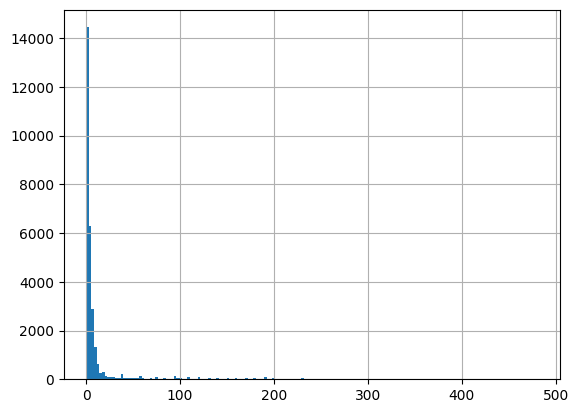

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
0,7.6,NTU,NaN,7.6 Nephelometric_Turbidity_Units
4,1,NTU,NaN,1.0 Nephelometric_Turbidity_Units
11,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
16,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
21,5.2,NTU,NaN,5.2 Nephelometric_Turbidity_Units
...,...,...,...,...
457229,1.6,NTRU,NaN,1.6 Nephelometric_Turbidity_Units
457239,5.8,NTRU,NaN,5.8 Nephelometric_Turbidity_Units
457243,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
457247,2.9,NTRU,NaN,2.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False, errors='ignore')

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
415893,0.012,g,NaN,NaN
415894,0.0037,g,NaN,NaN
415895,0.0048,g,NaN,NaN
415896,0.001,g,NaN,NaN
415897,0.0088,g,NaN,NaN
...,...,...,...,...
456318,0.0051,g,NaN,NaN
456392,0.0025,g,NaN,NaN
456464,0.002,g,NaN,NaN
456503,0.0023,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
65,0.049,mg/L,NaN,NaN
67,0.024,mg/L,NaN,NaN
71,0.05,mg/L,NaN,NaN
87,0.027,mg/L,NaN,NaN
106,0.059712,mg/L,NaN,NaN
...,...,...,...,...
456525,0.006,mg/l as P,NaN,0.006 milligram / liter
456537,0.016,mg/l as P,NaN,NaN
456538,0.008,mg/l as P,NaN,0.008 milligram / liter
456545,0.047,mg/l as P,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
65,0.049,mg/L,NaN,NaN
67,0.024,mg/L,NaN,NaN
71,0.05,mg/L,NaN,NaN
87,0.027,mg/L,NaN,NaN
106,0.059712,mg/L,NaN,NaN
...,...,...,...,...
456499,0.036,mg/l as P,NaN,NaN
456510,0.021,mg/l as P,NaN,NaN
456524,0.011,mg/l as P,NaN,NaN
456537,0.016,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
46491,0.023,ppm,NaN,0.023000000000000003 milligram / liter
50426,0.035,ppm,NaN,0.03500000000000001 milligram / liter
52416,0.017,ppm,NaN,0.017000000000000005 milligram / liter
52543,0.015,ppm,NaN,0.015000000000000003 milligram / liter
53907,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
456500,0.015,mg/l as P,NaN,0.015 milligram / liter
456511,0.005,mg/l as P,NaN,0.005 milligram / liter
456525,0.006,mg/l as P,NaN,0.006 milligram / liter
456538,0.008,mg/l as P,NaN,0.008 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
35395,0.03525375,mg/L,NaN,NaN
35464,0.107028125,mg/L,NaN,NaN
35973,0.0697675,mg/L,NaN,NaN
36237,0.04356,mg/L,NaN,NaN
36366,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
446652,530.0,mg/kg,NaN,NaN
447989,280.0,mg/kg,NaN,NaN
448763,270.0,mg/kg,NaN,NaN
449009,260.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5762
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.70806108734): 7


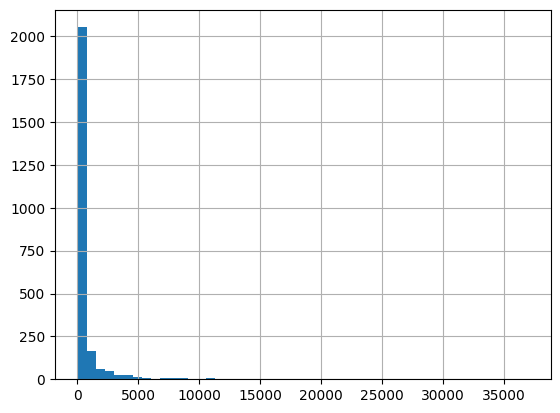

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
9833,40,#/100mL,NaN,NaN
9885,9,#/100mL,NaN,NaN
9900,20,#/100mL,NaN,NaN
10109,200,#/100mL,NaN,NaN
10305,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
452883,2400.0,cfu/100mL,NaN,NaN
452885,230.0,cfu/100mL,NaN,NaN
452893,30.0,cfu/100mL,NaN,NaN
452901,NaN,cfu/100mL,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'CFUcol/100mL' UNDEFINED UNIT for E_coli
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     5189.000000
mean       245.882382
std       1752.315000
min          0.000000
25%          0.500000
50%         30.000000
75%        128.000000
max      72000.000000
dtype: float64
Unusable results: 22197
Usable results with inferred units: 0
Results outside threshold (0.0 to 10759.772381268724): 14


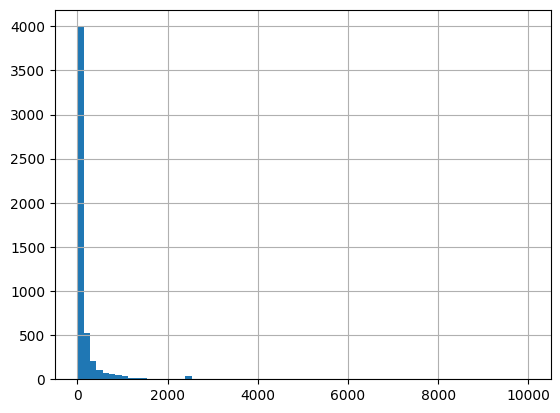

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
15,96,MPN/100mL,NaN,NaN
18,58,#/100mL,NaN,NaN
24,NaN,MPN/100mL,ResultMeasureValue: missing (NaN) result,NaN
37,24200,MPN/100mL,NaN,NaN
38,7270,MPN/100mL,NaN,NaN
...,...,...,...,...
457225,7.0,MPN/100 ml,NaN,7.0 Colony_Forming_Units / milliliter
457238,870.0,MPN/100 ml,NaN,870.0 Colony_Forming_Units / milliliter
457242,44.0,MPN/100 ml,NaN,44.0 Colony_Forming_Units / milliliter
457246,14.0,MPN/100 ml,NaN,14.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 36923 
Mean: 20.63888369988916 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
28273,804,ppth,NaN,804.0 Practical_Salinity_Units
143522,71.49,ppth,NaN,71.49 Practical_Salinity_Units
144531,70.62,ppth,NaN,70.62 Practical_Salinity_Units
213318,77.666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
424274,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [78]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
13197,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
13781,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
13968,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
20944,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
22582,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
363590,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
363646,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
363692,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
363738,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [79]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

2           590.0 microsiemens / centimeter
7         43500.0 microsiemens / centimeter
49          349.0 microsiemens / centimeter
52        49700.0 microsiemens / centimeter
83          443.0 microsiemens / centimeter
                        ...                
381877    20579.0 microsiemens / centimeter
381912    38432.0 microsiemens / centimeter
381919    37791.0 microsiemens / centimeter
381924    19003.0 microsiemens / centimeter
381943    40652.0 microsiemens / centimeter
Name: Conductivity, Length: 8694, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [80]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
218963,57700.0,uS/cm,NaN,NaN,57700.0 microsiemens / centimeter
270752,52.418,mS/cm,NaN,NaN,52418.0 microsiemens / centimeter
280935,51.618,mS/cm,NaN,NaN,51618.0 microsiemens / centimeter
268321,51.325,mS/cm,NaN,NaN,51325.0 microsiemens / centimeter
51000,51.05,mS/cm,NaN,NaN,51050.0 microsiemens / centimeter
...,...,...,...,...,...
6304,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
105239,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter
8095,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter
105324,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [81]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

218963    38.468 dimensionless
270752    34.521 dimensionless
280935    33.929 dimensionless
268321    33.713 dimensionless
51000      33.51 dimensionless
                  ...         
6304       0.012 dimensionless
105239     0.012 dimensionless
8095       0.012 dimensionless
105324     0.012 dimensionless
3825       0.012 dimensionless
Name: Salinity, Length: 8694, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
218963,2021-06-21,NaN,NaN
270752,2022-08-09,12:58:00,EST
280935,2022-08-09,13:25:00,EST
268321,2022-07-25,11:40:00,EST
51000,2016-08-15,NaN,NaN
...,...,...,...
457247,2024-01-08,12:00:00,EST
457248,2024-02-12,08:45:00,EST
457249,2024-02-12,08:45:00,EST
457250,2024-02-12,08:45:00,EST


In [83]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 167291 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
218963,2021-06-21,NaT
270752,2022-08-09,2022-08-09 17:58:00+00:00
280935,2022-08-09,2022-08-09 18:25:00+00:00
268321,2022-07-25,2022-07-25 16:40:00+00:00
51000,2016-08-15,NaT
...,...,...
457247,2024-01-08,2024-01-08 17:00:00+00:00
457248,2024-02-12,2024-02-12 13:45:00+00:00
457249,2024-02-12,2024-02-12 13:45:00+00:00
457250,2024-02-12,2024-02-12 13:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [84]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

110874    0.15
112336    0.15
73386     0.15
78101     0.15
111338    0.15
          ... 
320473    0.15
320504    0.15
320515    0.15
320573    0.15
320587    0.15
Name: ResultDepthHeightMeasure/MeasureValue, Length: 2460, dtype: float64

#### Characteristic to Column (long to wide format)

In [85]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Other_Phosphorus,QA_E_coli,QA_Carbon,QA_Temperature,QA_Chlorophyll,QA_Secchi,QA_Sediment,QA_Turbidity,QA_Nitrogen,QA_Fecal_Coliform
218963,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,2021-06-21,NaN,NaN,NARS_WQX-NWC_RI-10033,STORET-1040684142,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270752,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,2022-08-09,12:58:00,-0500,WTGHA-P3,STORET-1041330082,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280935,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,2022-08-09,13:25:00,-0500,WTGHA-P4,STORET-1041330098,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268321,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220725114000:FM:B,2022-07-25,11:40:00,-0500,WTGHA-P3,STORET-1041329903,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51000,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20160815:FM:B,2016-08-15,NaN,NaN,WTGHA-P3,STORET-1041309861,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457247,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,-0500,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457248,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457249,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457250,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [87]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

38079 fewer rows


In [88]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [89]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [90]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Salinity', 'QA_pH', 'QA_Conductivity',
       'QA_DO', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_E_coli', 'QA_Carbon', 'QA_Temperature', 'QA_Chlorophyll',
       'QA_Secchi', 'QA_Sediment', 'QA_Turbidity', 'QA_Nitrogen',
       'QA_Fecal_Coliform'],
      dtype='object')

In [91]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Other_Phosphorus,QA_E_coli,QA_Carbon,QA_Temperature,QA_Chlorophyll,QA_Secchi,QA_Sediment,QA_Turbidity,QA_Nitrogen,QA_Fecal_Coliform
218963,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,NARS_WQX-NWC_RI-10033,STORET,NaN,NaN,NaN,NaN,38.468 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270752,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,34.521 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280935,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,WTGHA-P4,STORET,NaN,NaN,NaN,NaN,33.929 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268321,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220725114000:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,33.713 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51000,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20160815:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,33.51 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'DetectionQuantitationLimitTypeName',
 'DetectionQuantitationLimitMeasure/MeasureValue',
 'DetectionQuantitationLimitMeasure/MeasureUnitCode',
 'QA_Conductivity',
 'QA_DO',
 'QA_TDP_Phosphorus',
 'QA_Carbon',
 'QA_Sediment']

<Axes: >

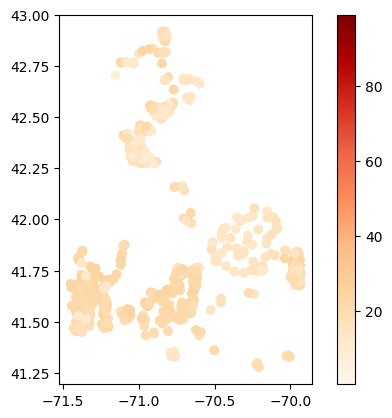

In [93]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)